In [2]:
import cv2 as cv
import numpy as np
import argparse
import random as rng
import matplotlib.pyplot as plt
%matplotlib inline

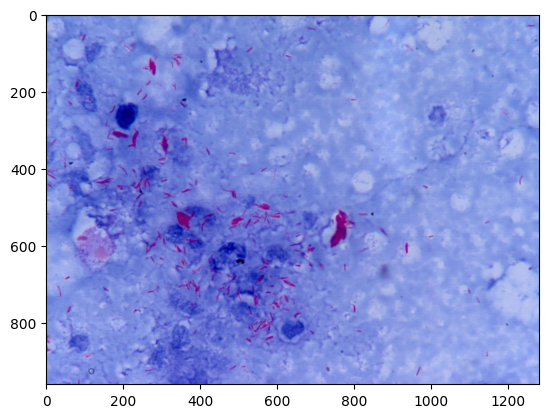

In [18]:
img = cv.imread("../UnLabelled/1.jpeg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [19]:
"""
TODO --> This is the big daddy function of this whole approach 

the goal is to shift the microscope focus on a particular "rectangle" of the given sample

With this way we can examine the sample for the exact no.of bacteria 

Now regarding the shifting of microscope focus , I believe we will need to adjust a single knob
which if I remember correctly changes the distance between the focal lenses 

Now ASSUMING a simple microscope there are 2 convex lenses that are used , one point towards the sample
the other towards the human eye forming the image
"""

def changeFocusMicroscope(img, pixel_x, pixel_y,width, height):
    human_eye_focus_distance = 25 # 25cm
    
    # Now we need to control the servos but since I have no experience programming hardware
    # I am making some few major assumptions
    # for moving the specimen around we have a 2 servos 1 on the x axis and 1 on the y axis
    
    # for moving the microscope around we have 1 servo , 
    # All are connected to an arduino which controls the servos 
    
    # Below is sample code for controlling a servo through micro python from an arduino
    
    #Source --> https://makerprojekt.com/portfolio/python-arduino-servo-control/
    """
    Python code --> 
    # servo control 15.12.2016
 
# 1) user set servo position in python
# 2) position is sent to arduino
# 3) arduino moves servo to position
# 4) arduino send confirmation message back to python
# 5) message is printed in python console
 
import serial                                           # import serial library
arduino = serial.Serial('/dev/cu.usbmodem1421', 9600)   # create serial object named arduino
while True:                                             # create loop
 
        command = str(input ("Servo position: "))       # query servo position
        arduino.write(command)                          # write position to serial port
        reachedPos = str(arduino.readline())            # read serial port for arduino echo
        print  reachedPos                               # print arduino echo to console
    

Arduino code

#include <Servo.h>
Servo myservo; 
String inByte;
int pos;

void setup() {
 
  myservo.attach(9);
  Serial.begin(9600);
}

void loop()
{    
  if(Serial.available())  // if data available in serial port
    { 
    inByte = Serial.readStringUntil('\n'); // read data until newline
    pos = inByte.toInt();   // change datatype from string to integer        
    myservo.write(pos);     // move servo
    Serial.print("Servo in position: ");  
    Serial.println(inByte);
    }
}
    
    """
    #but thats in the future for right now I am just writing a crop function
    final_img = np.zeros([height,width,3],dtype=int)
    for i in range(height):
        final_img[i] = img[pixel_y+i][pixel_x:pixel_x+width]
#     print(final_img)
#     plt.imshow(final_img)
#     plt.show()
    
    return final_img
    
# changeFocusMicroscope(img, 910,571,52,67)

Orignal Image


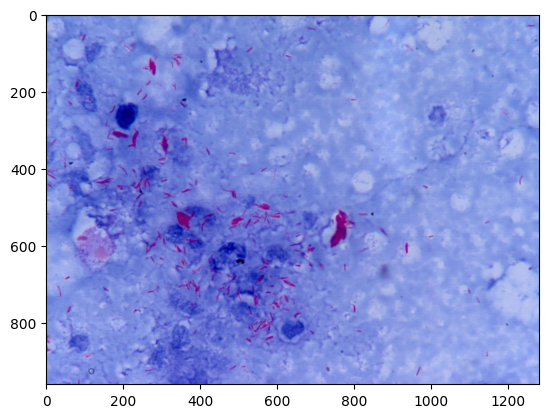

Contoured image: 


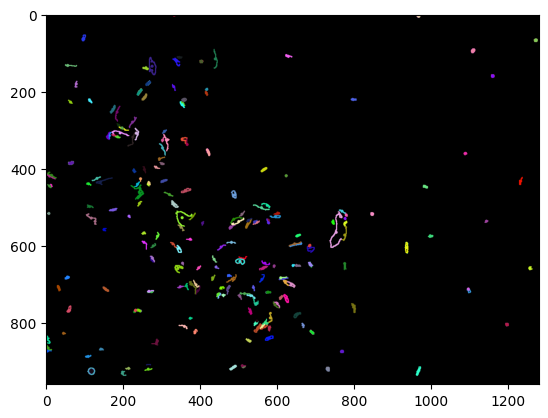

In [20]:
#Now to major problem 2 

#figuring out a way to distinguish bacteria to focus on is a problem that has many solutions, but right now 
# no one way stands out to me since you need to run several tests in different conditions to 
# get an idea of an optimal approach

# You can probably train a neural network to do it for you, but the whole reason we are even considering using 
# opencv is because "In terms of data, we have no data".

#Right now what I am implementing is not fancy or anything because you can probably use a correctly tune
# edge detection algo to get better results, but this is just to get something working

# So here's how it works , We get the contours of the image and then we focus the contour parts of the image
# This ensures that we have no dependence on color since , with scalability 
# since if we use color this will be a pain in the ass to do for different bacteria

#GETTING THE CONTOURS
def getContours(threshold):
    src_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    canny_output = cv.Canny(src_gray, threshold, threshold * 2)


    contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return contours

def draw_img(contours,threshold): 
    src_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    # Get the moments
    mu = [None]*len(contours)
    for i in range(len(contours)):
        mu[i] = cv.moments(contours[i])
    # Get the mass centers
    mc = [None]*len(contours)
    for i in range(len(contours)):
        # add 1e-5 to avoid division by zero
        mc[i] = (mu[i]['m10'] / (mu[i]['m00'] + 1e-5), mu[i]['m01'] / (mu[i]['m00'] + 1e-5))
    
    #Drawing
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 2)
        cv.circle(drawing, (int(mc[i][0]), int(mc[i][1])), 4, color, -1)
        
    plt.imshow(drawing)
    plt.show()

threshold = 110
print("Orignal Image")
plt.imshow(img)
plt.show()

print("Contoured image: ")
draw_img(getContours(threshold),threshold)

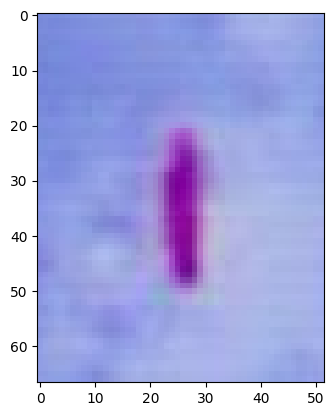

In [21]:
#Now I am assuming that somehow we focused the microscope on the required area 
zoomed_img = changeFocusMicroscope(img, 910,571,52,67) # Does not work right now using a dummy function call to exhibit

cv.imwrite("Zoomed/trial.jpg",zoomed_img)
#So now we have the below image , its blurred because I didn't have a higher resolution image
#this should not be a big problem in the real test

# zoomed_img = cv.cvtColor(cv.imread("Zoomed/1.jpg"),cv.COLOR_BGR2RGB)
plt.imshow(zoomed_img)
plt.show()

In [22]:
"""
And now we have 2 methods 

1) The one used in Approach 1, it will be very effective since its just got easier distinguish 
and its also very fast since no need to worry about anything else that the pixel values 

But thats boring and dependent on color

So in the name of doing something new 

2) We use edge detection and then calculate the average pixel count thereby no need to manually enter a specific 
average density for each bacteria life cycle count and it will also help get rid of the chance of human error 
completely
"""

'\nAnd now we have 2 methods \n\n1) The one used in Approach 1, it will be very effective since its just got easier distinguish \nand its also very fast since no need to worry about anything else that the pixel values \n\nBut thats boring and dependent on color\n\nSo in the name of doing something new \n\n2) We use edge detection and then calculate the average pixel count thereby no need to manually enter a specific \naverage density for each bacteria life cycle count and it will also help get rid of the chance of human error \ncompletely\n'

Orignal Image: 


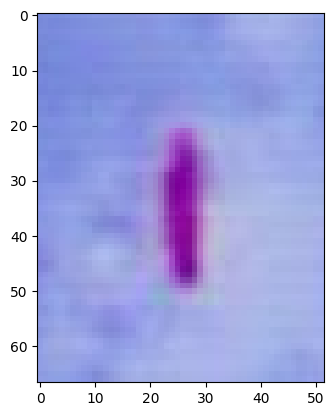

Contoured Image: 


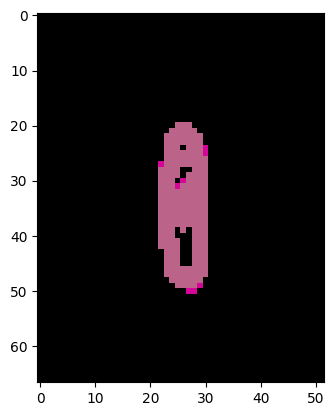

No. of non zero pixels:  270


In [23]:
#This is just what I rigged up in 10 min to get basic bacteria detection working

#FIRST ITERATION
# imgray = cv.cvtColor(zoomed_img, cv.COLOR_BGR2GRAY)
# ret, thresh = cv.threshold(imgray, 127, 255, 0)
# contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# print("Contours :\n" ,contours)
# cv.drawContours(zoomed_img, contours, -1, (0,255,0), 3)
# plt.imshow(zoomed_img)
# plt.show()

#SECOND ITERATION
# I Like this , it works decent but need a way to fix the black spots in between the contour
rng.seed(12345)
def thresh_callback(val):
    non_zero_pixels = 0
    threshold = val
    
    canny_output = cv.Canny(src_gray, threshold, threshold * 2)
    
    
    contours, _ = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Get the moments
    mu = [None]*len(contours)
    for i in range(len(contours)):
        mu[i] = cv.moments(contours[i])
    # Get the mass centers
    mc = [None]*len(contours)
    for i in range(len(contours)):
        # add 1e-5 to avoid division by zero
        mc[i] = (mu[i]['m10'] / (mu[i]['m00'] + 1e-5), mu[i]['m01'] / (mu[i]['m00'] + 1e-5))
    # Draw contours
    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours, i, color, 2)
        cv.circle(drawing, (int(mc[i][0]), int(mc[i][1])), 4, color, -1)
    
    
#     cv.imshow('Contours', drawing)
    plt.imshow(drawing)
    plt.show()
    
    # Calculate the area with the moments 00 and compare with the result of the OpenCV function
    for i in range(len(contours)):
#         print(' * Contour[%d] - Area (M_00) = %.2f - Area OpenCV: %.2f - Length: %.2f' % (i, mu[i]['m00'],
#                                                                                           cv.contourArea(contours[i]), cv.arcLength(contours[i], True)))
        non_zero_pixels += cv.contourArea(contours[i])
    return drawing,non_zero_pixels

src = cv.imread("Zoomed/trial.jpg")
if src is None:
    print('Could not open or find the image:', args.input)
    exit(0)
# Convert image to gray and blur it
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
src_gray = cv.blur(src_gray, (3,3))

max_thresh = 255
thresh = 110 # initial threshold

print("Orignal Image: ")
plt.imshow(zoomed_img)
plt.show()

print("Contoured Image: ")
drawing,non_zero_pixels = thresh_callback(thresh)

print("No. of non zero pixels: ",round(non_zero_pixels))
        

In [90]:
#Now we can either count them individually using the non_zero_pixel count as our base
# or we can use Approach 1

# Since approach 1 already explains the use of average bacteria per pixel I believe there is no need 
# to go further